# Imports

In [64]:
import pandas as pd

# Leitura do arquivo de variaveis

In [65]:
df_feature = pd.read_parquet(
    "s3://tech-challenge-3-models/feature-store/variables/variables.parquet"
)

# Remoção de colunas

As colunas que não são necessárias para o modelo ser treinado, são removidas.

O motivo foi identificarmos que essas variáveis não são relevantes para o modelo.

In [66]:
df_feature_test = df_feature.drop(
    columns=[
        "player_id",
        "age",
        "days_unknown_injury",
        "days_corona_virus",
        "gamesmissed_unknown_injury",
        "gamesmissed_corona_virus",
    ]
)

# Verificando a distribuição dos dados

In [67]:
df_feature["target"].value_counts(normalize=True) * 100

target
0    88.203018
1    11.796982
Name: proportion, dtype: float64

# Separação dos dados

In [68]:
from sklearn.model_selection import train_test_split

X = df_feature_test.drop(columns="target")
y = df_feature_test["target"]

# Equalização da base de dados

In [69]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [70]:
y_resampled.value_counts(normalize=True) * 100

target
0    50.0
1    50.0
Name: proportion, dtype: float64

# Separação dos dados em treino e teste utilizando a lógica 75/25

In [71]:
x_train, x_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, random_state=42
)

# Normalizando os dados para deixar as escalas de grandeza similares

In [72]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

scaler = MinMaxScaler()

pipeline = Pipeline([("scaler", scaler)])

pipeline.fit(x_train, y_train)

x_train_scaled = pipeline.fit_transform(x_train)
x_test_scaled = pipeline.fit_transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=X.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=X.columns)

In [73]:
print(pipeline)

Pipeline(steps=[('scaler', MinMaxScaler())])


In [74]:
print(scaler)

MinMaxScaler()


# Testando os melhores hiperparâmetros para o modelo de random forest e treino do modelo

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Definir os parâmetros a serem testados
param_grid = {
    "n_estimators": [150, 200, 250],
    "max_depth": [8, 12, 16],
    "class_weight": ["balanced", "balanced_subsample"],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
}

# Inicializar o classificador Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Realizar a busca em grade para encontrar os melhores parâmetros
grid_search = GridSearchCV(rf_classifier, param_grid, cv=10, scoring="accuracy")
grid_search.fit(x_train_scaled, y_train)

# Utilizar o modelo com os melhores parâmetros
best_rf_classifier = grid_search.best_estimator_

# Treinar o modelo com todos os dados de treinamento
best_rf_classifier.fit(x_train_scaled, y_train)

# Prever os rótulos para os dados de teste
y_pred = best_rf_classifier.predict(x_test)

scores = cross_val_score(
    best_rf_classifier, x_train_scaled, y_train, cv=10, scoring="accuracy"
)

print(scores)
print(best_rf_classifier)
print("Acurácia média com validação cruzada:", scores.mean())

[0.95876289 0.93814433 0.91752577 0.95876289 0.94791667 0.92708333
 0.96875    0.95833333 0.92708333 0.98958333]
RandomForestClassifier(class_weight='balanced_subsample', max_depth=16,
                       n_estimators=250, random_state=42)
Acurácia média com validação cruzada: 0.9491945876288661


# Avaliando o desempenho do modelo

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       174
           1       0.97      0.88      0.92       148

    accuracy                           0.93       322
   macro avg       0.94      0.93      0.93       322
weighted avg       0.93      0.93      0.93       322



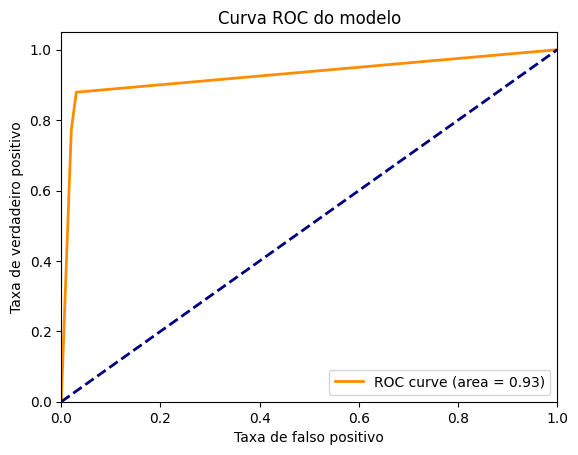

[[170   4]
 [ 18 130]]


In [76]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

best_rf_classifier.fit(x_train_scaled, y_train)

y_pred = best_rf_classifier.predict(x_test_scaled)

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


fpr_smooth = np.linspace(fpr[0], fpr[-1], 100)
tpr_smooth = np.interp(fpr_smooth, fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr_smooth,
    tpr_smooth,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taxa de falso positivo")
plt.ylabel("Taxa de verdadeiro positivo")
plt.title("Curva ROC do modelo")
plt.legend(loc="lower right")
plt.show()

matriz = confusion_matrix(y_test, y_pred)
print(matriz)

<module 'matplotlib.pyplot' from '/home/bruno/repos/coleta-transfermarkt/venv/lib64/python3.11/site-packages/matplotlib/pyplot.py'>

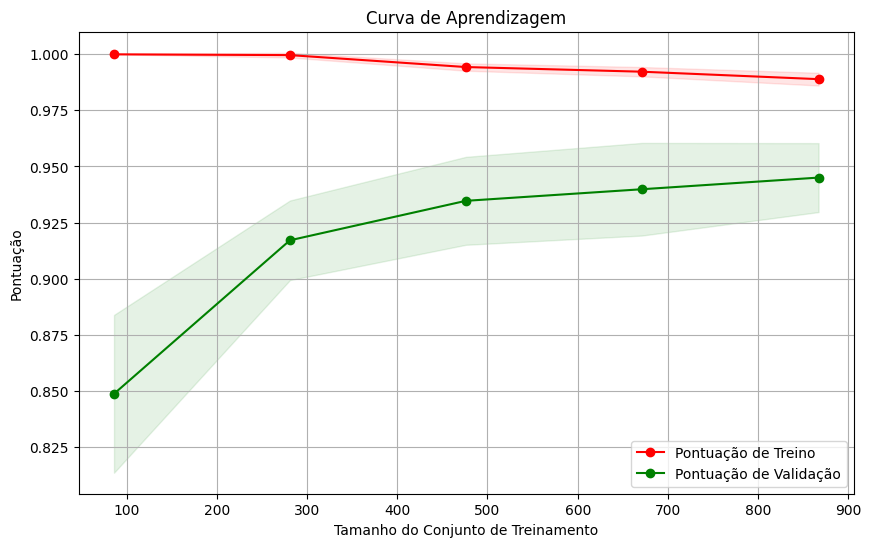

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


# Função para plotar a curva de aprendizagem
def plot_learning_curve(
    estimator,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    plt.figure(figsize=(10, 6))
    plt.title("Curva de Aprendizagem")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Tamanho do Conjunto de Treinamento")
    plt.ylabel("Pontuação")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Pontuação de Treino"
    )
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Pontuação de Validação"
    )

    plt.legend(loc="best")
    return plt


plot_learning_curve(best_rf_classifier, x_train_scaled, y_train, cv=10)

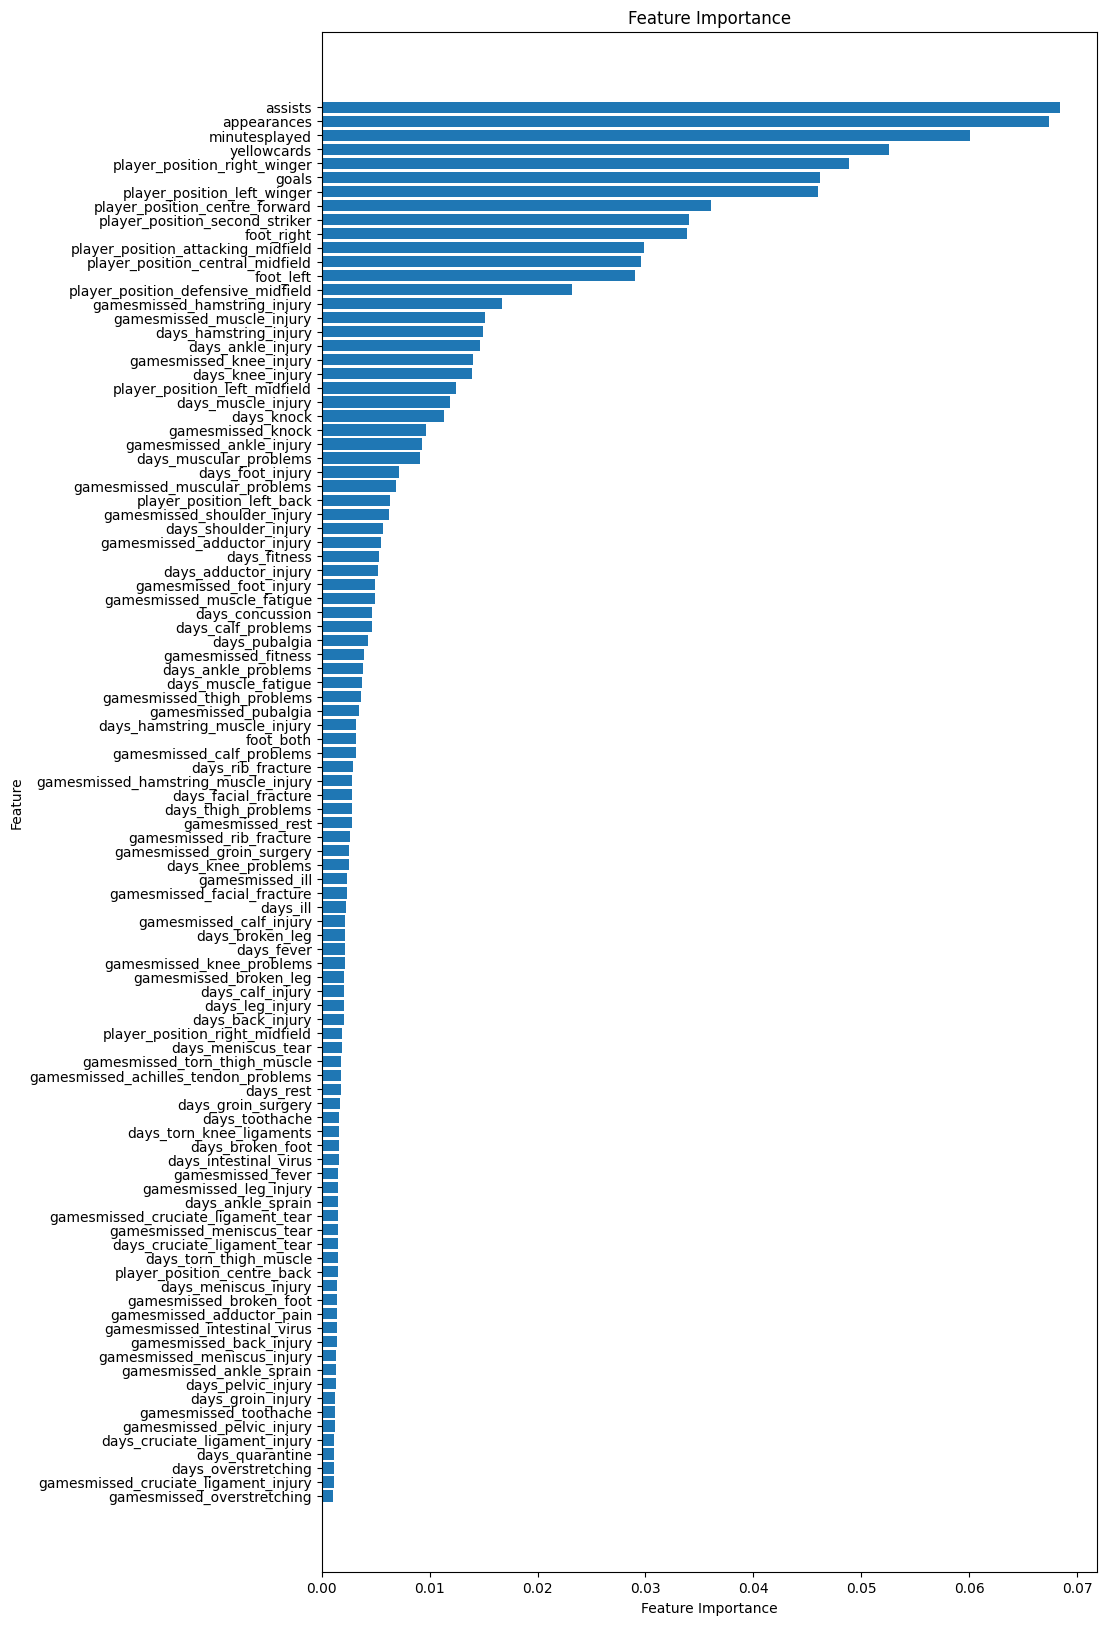

In [78]:
# Calcular importância das features
# Calcula a importância das features (atributos) usando um método chamado diminuição média da impureza para um modelo de Random Forest Classifier
feature_importance = best_rf_classifier.feature_importances_

# Plotar importância das features
plt.figure(figsize=(10, 20))
sorted_idx = np.argsort(feature_importance)[-100:]
features = df_feature_test.columns
plt.barh(features[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [79]:
import pickle

In [80]:
with open("pkl/random_forest.pkl", "wb") as f:
    pickle.dump(best_rf_classifier, f)

In [81]:
with open("pkl/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
